In [96]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import json

CITY = 'Lisboa'
plt.rcParams['figure.figsize'] = [12, 6]

***
# <center>**Dataset Creation**<center>
***

## **1. JSON Loading**

In [97]:
dataset = pd.read_json('./data.json', lines = True)
dataset.head()

,datetime,city,lat,lon,weather,traffic,airPollution
0,2022-04-17 13:34:00,Lisboa,38.707100,-9.13549,"{'coord': {'lon': -9.1355, 'lat': 38.7071}, 'w...","{'flowSegmentData': {'frc': 'FRC2', 'currentSp...","{'coord': {'lon': -9.1355, 'lat': 38.7071}, 'l..."
1,2022-04-17 13:34:00,Porto,41.149610,-8.61099,"{'coord': {'lon': -8.611, 'lat': 41.1496}, 'we...","{'flowSegmentData': {'frc': 'FRC4', 'currentSp...","{'coord': {'lon': -8.611, 'lat': 41.1496}, 'li..."
2,2022-04-17 13:34:00,Faro,37.019356,-7.93044,"{'coord': {'lon': -7.9304, 'lat': 37.0194}, 'w...","{'flowSegmentData': {'frc': 'FRC3', 'currentSp...","{'coord': {'lon': -7.9304, 'lat': 37.0194}, 'l..."
3,2022-04-17 13:44:02,Lisboa,38.707100,-9.13549,"{'coord': {'lon': -9.1355, 'lat': 38.7071}, 'w...","{'flowSegmentData': {'frc': 'FRC2', 'currentSp...","{'coord': {'lon': -9.1355, 'lat': 38.7071}, 'l..."
4,2022-04-17 13:44:02,Porto,41.149610,-8.61099,"{'coord': {'lon': -8.611, 'lat': 41.1496}, 'we...","{'flowSegmentData': {'frc': 'FRC4', 'currentSp...","{'coord': {'lon': -8.611, 'lat': 41.1496}, 'li..."


### **1.1. Traffic**

In [98]:
for index, values in dataset.iterrows():

    features = re.split(r', ', re.split(r': ', str(values['traffic']), 1)[1])
    
    for f in features:

        if re.search(r'frc', f) or re.search(r'longitude', f) or re.search(r'latitude', f) or re.search(r'@version', f) or re.search(r'coordinates', f):
            pass
        
        elif re.search(r'roadClosure', f):
            pair = re.split(r': ', f)
            dataset.loc[dataset.index[index], re.sub(r'\'', r'', pair[0])] = 1 if re.sub(r'\'', r'', pair[1]) == 'True' else 0

        else:
            pair = re.split(r': ', f)
            dataset.loc[dataset.index[index], re.sub(r'\'', r'', pair[0])] = float(pair[1])

dataset = dataset.drop(['traffic', 'roadClosure', 'confidence'],  axis = 1)
dataset = dataset.convert_dtypes()
dataset.head()

,datetime,city,lat,lon,weather,airPollution,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime
0,2022-04-17 13:34:00,Lisboa,38.7071,-9.13549,"{'coord': {'lon': -9.1355, 'lat': 38.7071}, 'w...","{'coord': {'lon': -9.1355, 'lat': 38.7071}, 'l...",15,29,36,18
1,2022-04-17 13:34:00,Porto,41.14961,-8.61099,"{'coord': {'lon': -8.611, 'lat': 41.1496}, 'we...","{'coord': {'lon': -8.611, 'lat': 41.1496}, 'li...",15,15,31,31
2,2022-04-17 13:34:00,Faro,37.019356,-7.93044,"{'coord': {'lon': -7.9304, 'lat': 37.0194}, 'w...","{'coord': {'lon': -7.9304, 'lat': 37.0194}, 'l...",28,28,148,148
3,2022-04-17 13:44:02,Lisboa,38.7071,-9.13549,"{'coord': {'lon': -9.1355, 'lat': 38.7071}, 'w...","{'coord': {'lon': -9.1355, 'lat': 38.7071}, 'l...",30,30,18,18
4,2022-04-17 13:44:02,Porto,41.14961,-8.61099,"{'coord': {'lon': -8.611, 'lat': 41.1496}, 'we...","{'coord': {'lon': -8.611, 'lat': 41.1496}, 'li...",15,15,31,31


### **1.2. Weather**

In [99]:
for index, values in dataset.iterrows():
    json_string = re.sub(r'\'', r'"', str(values['weather']))
    json_object = json.loads(json_string)

    weather_desc = re.split(r', ', str(json_object['weather']))
    temperature = re.split(r', ', str(json_object['main']))
    wind = re.split(r', ', str(json_object['wind']))
    clouds = re.split(r', ', str(json_object['clouds']))
    
    if 'rain' in json_object:
        rain = re.split(r', ', str(json_object['rain']))
    else:
        rain = ['nan']

    for wd in weather_desc:
        if re.search(r'main', wd) or re.search(r'description', wd):
            pair = re.split(r': ', wd)
            dataset.loc[dataset.index[index], re.sub(r'\'', r'', pair[0])] = re.sub(r'\'', r'', pair[1])

    for t in temperature:
        pair = re.split(r': ', re.sub(r'[\{\}]', r'', t))
        dataset.loc[dataset.index[index], re.sub(r'\'', r'', pair[0])] = round(float(pair[1]), 3)

    for w in wind:
        pair = re.split(r': ', re.sub(r'[\{\}]', r'', w))
        dataset.loc[dataset.index[index], re.sub(r'\'', r'', pair[0])] = round(float(pair[1]), 3)

    for c in clouds:    
        pair = re.split(r': ', re.sub(r'[\{\}]', r'', c))
        dataset.loc[dataset.index[index], 'cloudiness (%)'] = int(pair[1])

    for r in rain:
        if not re.search(r'nan', r):
            pair = re.split(r': ', re.sub(r'[\{\}]', r'', r))
            dataset.loc[dataset.index[index], re.sub(r'\'', r'', 'rain')] = round(float(pair[1]), 3)
        else:
            dataset.loc[dataset.index[index], re.sub(r'\'', r'', 'rain')] = 0.0

dataset['gust'] = dataset['gust'].fillna(0)
dataset = dataset.drop(['weather'], axis = 1)
dataset = dataset.convert_dtypes()
dataset.head()

,datetime,city,lat,lon,airPollution,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,main,...,temp_max,pressure,humidity,speed,deg,cloudiness (%),rain,gust,sea_level,grnd_level
0,2022-04-17 13:34:00,Lisboa,38.7071,-9.13549,"{'coord': {'lon': -9.1355, 'lat': 38.7071}, 'l...",15,29,36,18,Clouds,...,22.34,1015,59,7.2,340,20,0.0,0.0,<NA>,<NA>
1,2022-04-17 13:34:00,Porto,41.14961,-8.61099,"{'coord': {'lon': -8.611, 'lat': 41.1496}, 'li...",15,15,31,31,Clouds,...,22.89,1020,68,4.12,300,20,0.0,0.0,<NA>,<NA>
2,2022-04-17 13:34:00,Faro,37.019356,-7.93044,"{'coord': {'lon': -7.9304, 'lat': 37.0194}, 'l...",28,28,148,148,Clear,...,26.63,1017,53,3.6,180,0,0.0,0.0,<NA>,<NA>
3,2022-04-17 13:44:02,Lisboa,38.7071,-9.13549,"{'coord': {'lon': -9.1355, 'lat': 38.7071}, 'l...",30,30,18,18,Clouds,...,22.51,1014,58,9.77,350,20,0.0,0.0,<NA>,<NA>
4,2022-04-17 13:44:02,Porto,41.14961,-8.61099,"{'coord': {'lon': -8.611, 'lat': 41.1496}, 'li...",15,15,31,31,Clear,...,22.89,1019,68,4.12,300,0,0.0,0.0,<NA>,<NA>


### **1.3. Air Pollution**

In [100]:
for index, values in dataset.iterrows():
    json_string = re.sub(r'\'', r'"', str(values['airPollution']))
    json_object = json.loads(json_string)

    features = re.split(r', ', str(json_object['list']))   

    for f in features:
        f = re.sub(r'[\{\}]', r'', f)

        if re.search(r'dt', f):
            pair = re.split(r': ', f)
            dataset.loc[dataset.index[index], re.sub(r'\'', r'', pair[0])] = str(pair[1][:-1])

        elif re.search(r'main', f) or re.search(r'components', f):
            pair = re.split(r': ', f)
            dataset.loc[dataset.index[index], re.sub(r'\'', r'', pair[1])] = round(float(pair[2]), 3)

        else:
            pair = re.split(r': ', f)
            dataset.loc[dataset.index[index], re.sub(r'\'', r'', pair[0])] = round(float(pair[1]), 3)


dataset = dataset.drop(['airPollution'], axis = 1)
dataset = dataset.convert_dtypes()
dataset = dataset.drop(['dt', 'sea_level', 'grnd_level'], axis = 1)
dataset.head()

,datetime,city,lat,lon,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,main,description,...,gust,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2022-04-17 13:34:00,Lisboa,38.7071,-9.13549,15,29,36,18,Clouds,few clouds,...,0.0,2,213.62,0.25,1.15,108.72,1.25,3.58,7.15,1.5
1,2022-04-17 13:34:00,Porto,41.14961,-8.61099,15,15,31,31,Clouds,few clouds,...,0.0,2,213.62,0.21,1.31,103.0,1.91,7.58,12.97,1.31
2,2022-04-17 13:34:00,Faro,37.019356,-7.93044,28,28,148,148,Clear,clear sky,...,0.0,2,193.6,0.06,0.34,101.57,0.12,4.56,12.71,1.11
3,2022-04-17 13:44:02,Lisboa,38.7071,-9.13549,30,30,18,18,Clouds,few clouds,...,0.0,2,213.62,0.25,1.15,108.72,1.25,3.58,7.15,1.5
4,2022-04-17 13:44:02,Porto,41.14961,-8.61099,15,15,31,31,Clear,clear sky,...,0.0,2,213.62,0.21,1.31,103.0,1.91,7.58,12.97,1.31


***
# <center>**Data Description and Exploration**<center>
***

## **1. Traffic**

### **1.1. Description**

&emsp; &emsp; `currentSpeed -` A velocidade média atual do local selecionado, em `km/h` (quilometros por hora). O valor é calculado a partir do &emsp;`currentTravelTime` e do comprimento do segmento selecionado.

&emsp; &emsp; `freeFlowSpeed -` A velocidade de tráfego livre esperada em condições ideais, expressa em `km/h`. Este valor está relacionado com `freeFlowTravelTime`.

&emsp; &emsp; `currentTravelTime -` O tempo de viagem atual em `segundos` com base em medições em tempo real entre os locais definidos na direção especificada.

&emsp; &emsp; `freeFlowTravelTime -` O tempo de viagem em `segundos` que seria esperado em condições ideais de tráfego livre.

### **1.2. Exploration**

<AxesSubplot:xlabel='currentSpeed', ylabel='Count'>

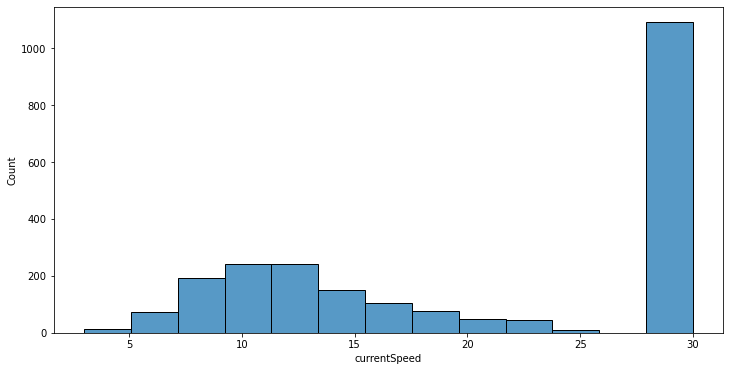

In [101]:
# Histograma da distribuição de velocidade média atual

sns.histplot(dataset[dataset.city == CITY]["currentSpeed"])

<AxesSubplot:xlabel='freeFlowSpeed', ylabel='Count'>

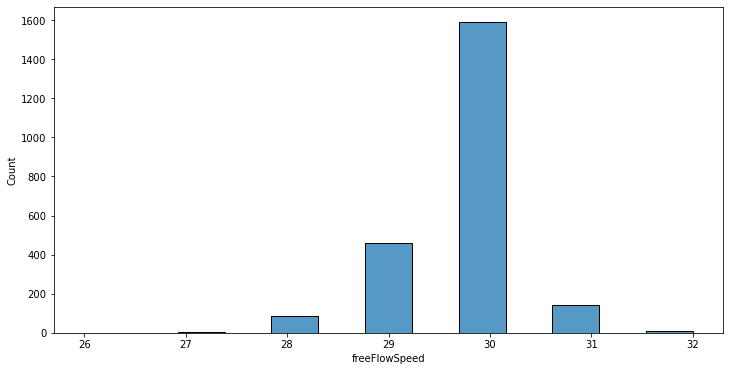

In [102]:
# Histograma da distribuição de velocidade expectável em condições ideais

sns.histplot(dataset[dataset.city == CITY]["freeFlowSpeed"])

<AxesSubplot:xlabel='currentTravelTime', ylabel='Count'>

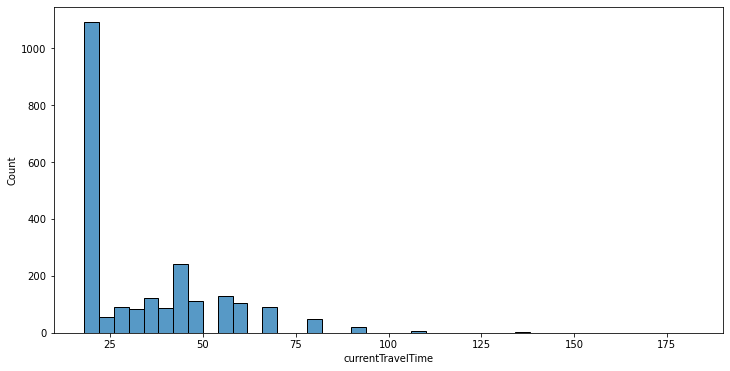

In [103]:
# Histograma da distribuição do tempo de viagem atual

sns.histplot(dataset[dataset.city == CITY]["currentTravelTime"])

<AxesSubplot:xlabel='freeFlowTravelTime', ylabel='Count'>

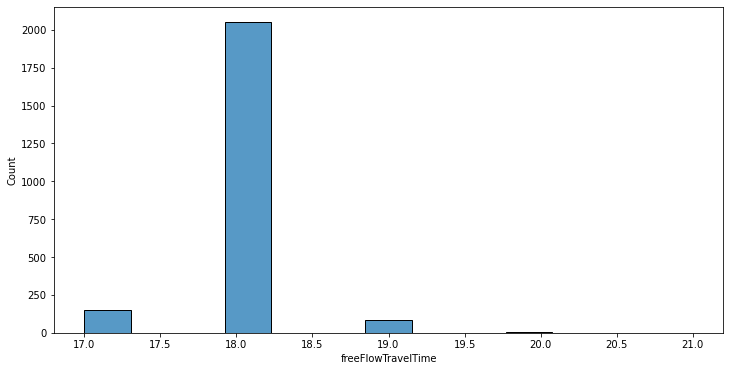

In [104]:
# Histograma da distribuição do tempo de viagem em condições ideais

sns.histplot(dataset[dataset.city == CITY]["freeFlowTravelTime"])

#### **1.2.1. Average Speed Difference**

## <center> **`asd = |ffs - cs|`** <center>

##### <center> `asd -` averageSpeedDifference <center>
##### <center> `ffs -` freeFlowSpeed<center>
##### <center> `cs -` currentSpeed<center>

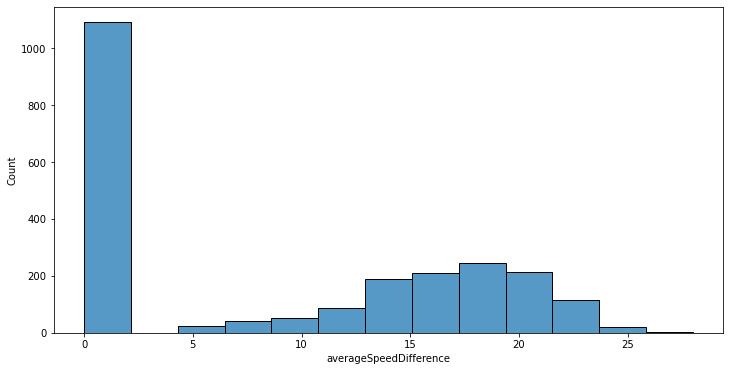

In [105]:
for index, values in dataset.iterrows():
    dataset.loc[dataset.index[index], 'averageSpeedDifference'] = int(abs(dataset.loc[dataset.index[index], 'freeFlowSpeed'] - 
                                                                        dataset.loc[dataset.index[index], 'currentSpeed']))


# Histograma da distribuição do valor absoluto da diferença entre a velocidade expectável em condições ideais e a velocidade média

sns.histplot(dataset[dataset.city == CITY]["averageSpeedDifference"])
dataset = dataset.convert_dtypes()

#### **1.2.2. Average Time Difference**

## <center> **`atd = |fftt - ctt|`** <center>

##### <center> `atd -` averageTimeDifference <center>
##### <center> `fftt -` freeFlowTravelTime<center>
##### <center> `ctt -` currentTravelTime<center>

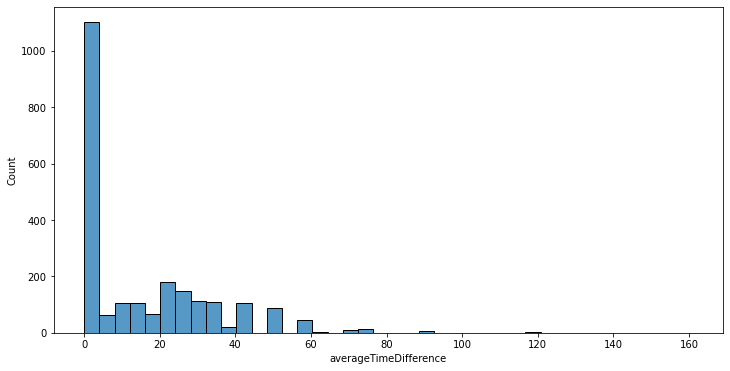

In [106]:
for index, values in dataset.iterrows():
    dataset.loc[dataset.index[index], 'averageTimeDifference'] = int(abs(dataset.loc[dataset.index[index], 'freeFlowTravelTime'] - 
                                                                        dataset.loc[dataset.index[index], 'currentTravelTime']))


# Histograma da distribuição do valor absoluto da diferença entre o tempo de viagem em condições ideais e o tempo de viagem atual

sns.histplot(dataset[dataset.city == CITY]["averageTimeDifference"])
dataset = dataset.convert_dtypes()

#### **1.2.3. Datetime division**

In [107]:
dataset['datetime'] = pd.to_datetime(dataset['datetime'])

# weekday - Monday = 0, Sunday = 6
dataset['day'] = dataset.datetime.dt.weekday
dataset['year'] = dataset.datetime.dt.year
dataset['month'] = dataset.datetime.dt.month
dataset['week'] = dataset.datetime.dt.isocalendar().week
dataset['hour'] = dataset.datetime.dt.hour
dataset['minute'] = dataset.datetime.dt.minute

dataset = dataset.drop(['datetime'], axis = 1)

C:\Users\ASUS\anaconda3\envs\aula1\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:xlabel='hour', ylabel='averageSpeedDifference'>

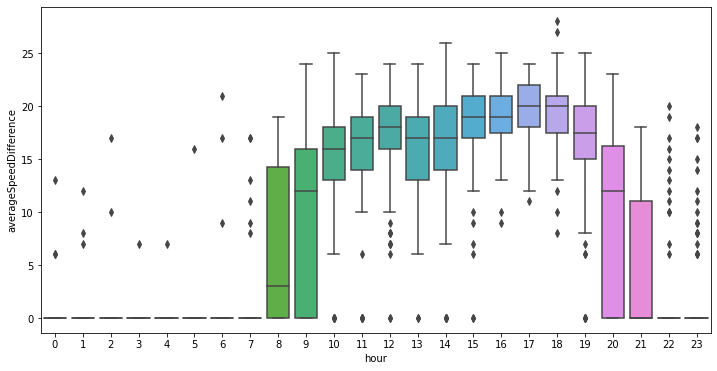

In [108]:
# Boxplot do average speed difference para as horas do dia

sns.boxplot(x = dataset[dataset.city == CITY][dataset.city == CITY].hour, y = dataset.averageSpeedDifference)

<AxesSubplot:xlabel='hour', ylabel='averageTimeDifference'>

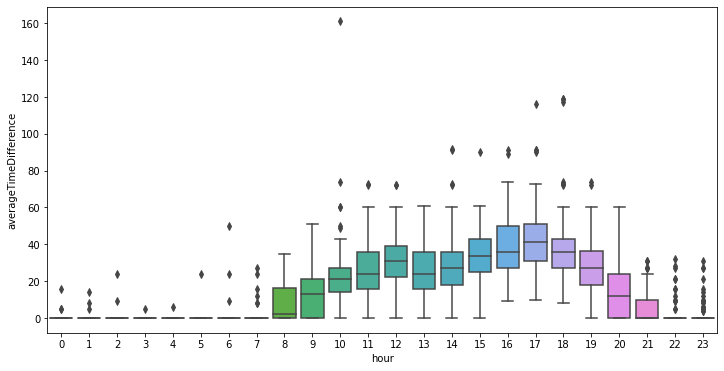

In [109]:
# Boxplot do average time difference para as horas do dia

sns.boxplot(x = dataset[dataset.city == CITY].hour, y = dataset[dataset.city == CITY].averageTimeDifference)

<AxesSubplot:xlabel='day', ylabel='averageSpeedDifference'>

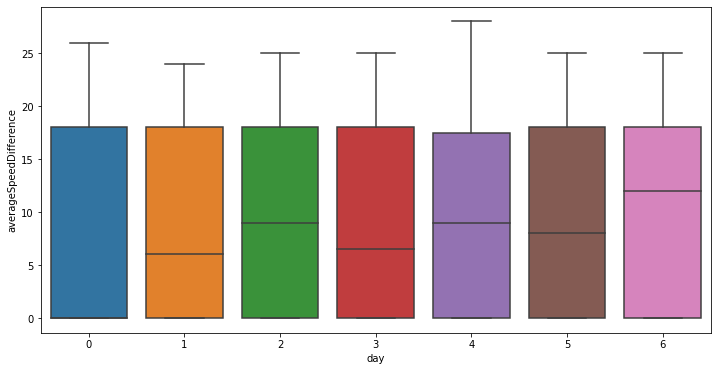

In [110]:
# Boxplot do average speed difference para os dias da semana

sns.boxplot(x = dataset[dataset.city == CITY].day, y = dataset[dataset.city == CITY].averageSpeedDifference)

<AxesSubplot:xlabel='day', ylabel='averageTimeDifference'>

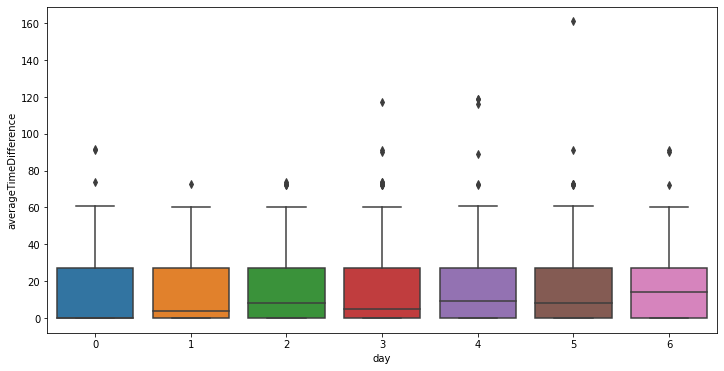

In [111]:
# Boxplot do average time difference para os dias da semana

sns.boxplot(x = dataset[dataset.city == CITY].day, y = dataset[dataset.city == CITY].averageTimeDifference)

### **1.3. Problems and Solutions**

&emsp; &emsp; `-` Turismo, verificar os pontos turísticos cujo o tempo nas filas de espera rodoviárias é melhor para possível visita

&emsp; &emsp; `-` Lazer, verificar os dias da semana que melhor se adequam a uma saida

&emsp; &emsp; `-` Redução da congestão, uma vez que sabendo os picos diários de tráfego é possível distribuir uniformemente as saidas de casa, 
trabalho, etc

&emsp; &emsp; `-` Planeamento urbano, dado que cidades com alta movimentação rodoviária são excelentes pontos de partida para <br> &emsp; &ensp; &emsp; inovação de espaços e infraestruturas

&emsp; &emsp; `-` A otimização de pontos sublinhados anteriormente pode se debruçar em prosperidade no consumo energéticos de carros elétricos, energias <br> &emsp; &ensp; &emsp; não renováveis como petróleo e, por outro lado, o aproveitamento dos transportes públicos

&emsp; &emsp; `-` Previsão de tráfego rodoviário, para efeitos de prevenção ou adoção de pontos acima mencionados

***

## **2. Weather**

### **2.1. Description**

&emsp; &emsp; `main -` A condição geral do tempo.

&emsp; &emsp; `rain -` O volume de chuva na última hora em mm.

&emsp; &emsp; `description -` A condição mais detalhada do estado do céu.

&emsp; &emsp; `temp -` A temperatura medida para o momento.

&emsp; &emsp; `feels_like -` A temperatura sentida por uma pessoa para o momento.

&emsp; &emsp; `temp_min -` A temperatura mínima para o momento.

&emsp; &emsp; `temp_max -` A temperatura máxima para o momento.

&emsp; &emsp; `pressure -` A pressão atmosférica ao nível do mar, em hPa, para o momento.

&emsp; &emsp; `humidity -` A percentagem de humidade no ar.

&emsp; &emsp; `speed -` A velocidade do vento em m/s.

&emsp; &emsp; `deg -` O sentido do vento. (Norte - 0, Este - 90, Sul - 180, Oeste - 270)

&emsp; &emsp; `cloudiness `- A percentagem do céu coberta por nuvens.

&emsp; &emsp; `gust -` A rajada do vento em m/s.

### **2.2. Exploration**

<AxesSubplot:xlabel='city', ylabel='temp'>

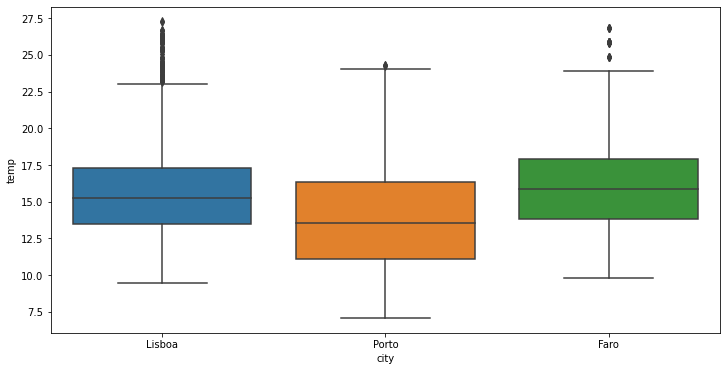

In [112]:
# Boxplot por cidade para temperatura

sns.boxplot(x = dataset.city, 
            y = dataset.temp)

<AxesSubplot:xlabel='city', ylabel='rain'>

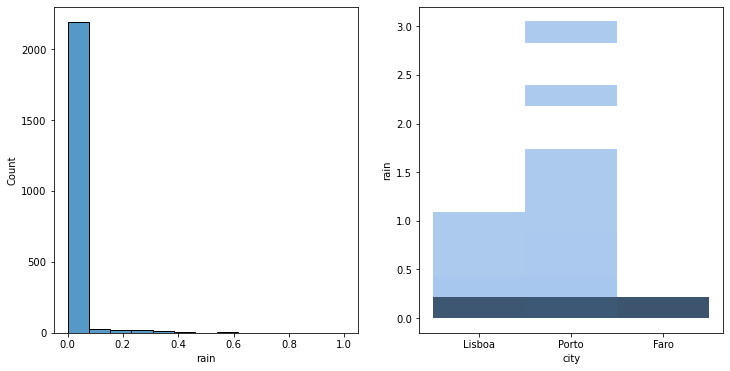

In [113]:
_, axis = plt.subplots(1, 2)

# Histograma por cidade para quantidade de chuva
sns.histplot(dataset[dataset.city == CITY]["rain"], 
             ax = axis[0])


# Boxplot por cidade para quantidade de chuva

sns.histplot(x = dataset.city, 
            y = dataset.rain, ax = axis[1])

<AxesSubplot:xlabel='city', ylabel='humidity'>

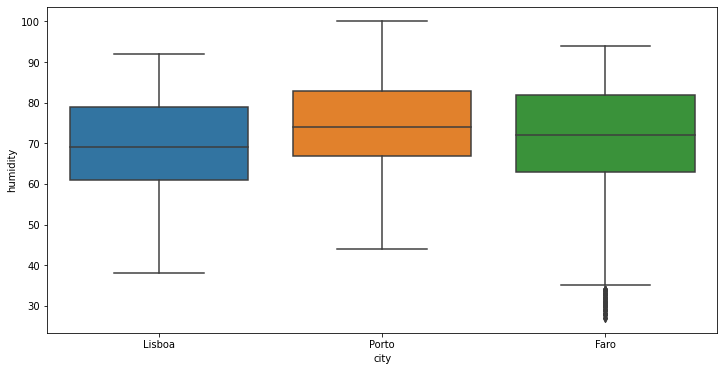

In [114]:
# Boxplot por cidade para humidade

sns.boxplot(x = dataset.city, 
            y = dataset.humidity)

<AxesSubplot:xlabel='city', ylabel='pressure'>

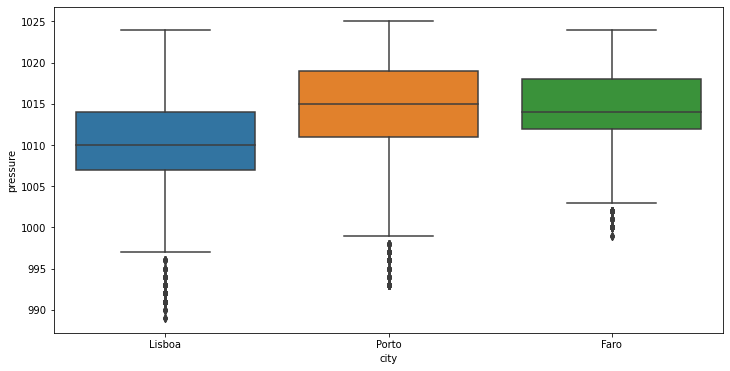

In [115]:
# Boxplot por cidade para pressão atmosférica

sns.boxplot(x = dataset.city, 
            y = dataset.pressure)

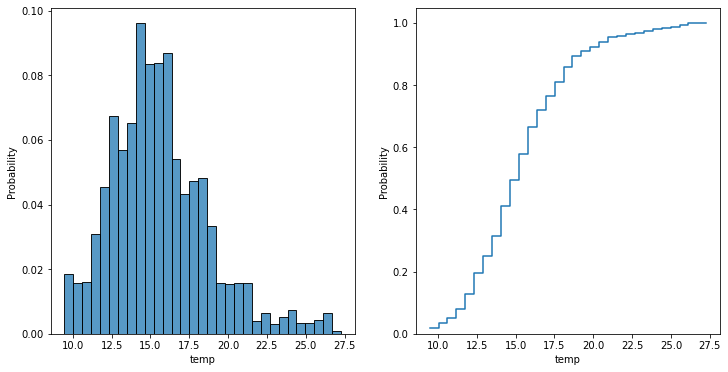

In [116]:
_, axis = plt.subplots(1, 2)


# Histograma das probabilidades de cada temperatura

sns.histplot(dataset[dataset.city == CITY]["temp"], 
             stat = 'probability', ax = axis[0])


# Gráfico da Função distribuição acumulada das temperaturas

sns.histplot(dataset[dataset.city == CITY]["temp"], 
             stat = 'probability', 
             cumulative = True, 
             fill = False, 
             element = 'step', ax = axis[1])


plt.show()

<AxesSubplot:ylabel='Distribuição da condição geral'>

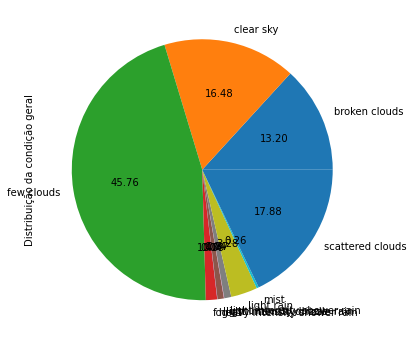

In [117]:
# Distribuição da condição geral de tempo

dataset[dataset['city'] == CITY].groupby('description').size().plot(kind = 'pie', 
                                           autopct = '%.2f', 
                                           ylabel = 'Distribuição da condição geral')

<AxesSubplot:xlabel='deg', ylabel='Count'>

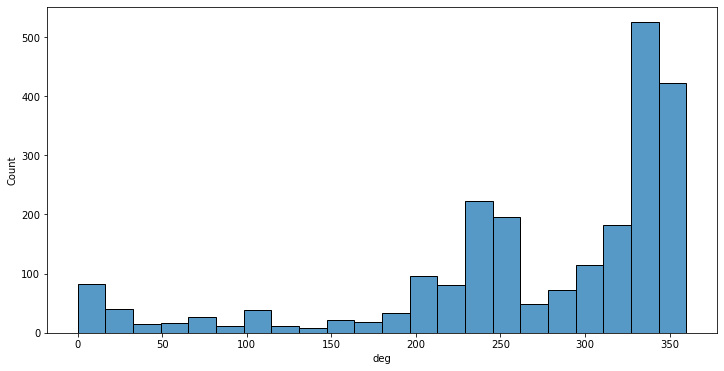

In [118]:
# Probabilidade da direção do vento

sns.histplot(dataset[dataset['city'] == CITY]['deg'])

<AxesSubplot:xlabel='speed', ylabel='Probability'>

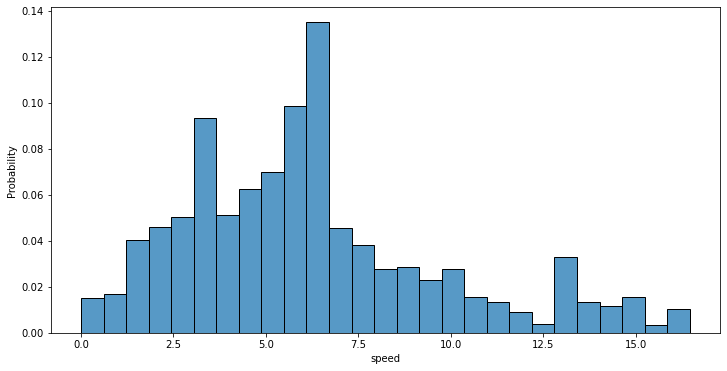

In [119]:
# Probabilidade da velocidade do vento

sns.histplot(dataset[dataset['city'] == CITY]['speed'], 
             stat = 'probability')

<AxesSubplot:xlabel='humidity', ylabel='Count'>

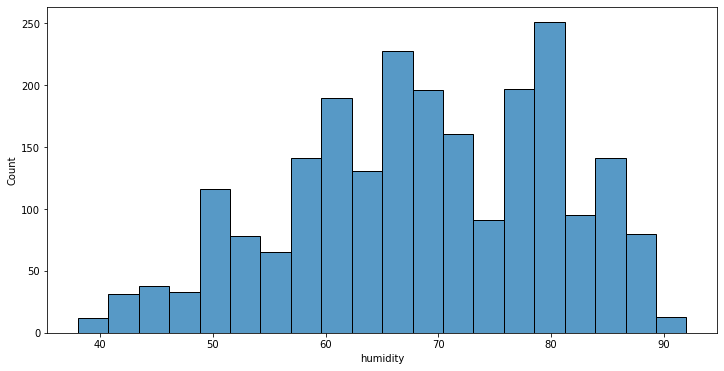

In [120]:
# Histograma da distribuição da humidade

sns.histplot(dataset[dataset.city == CITY]["humidity"])

### **2.3. Problems and Solutions**

### 2.3.1. Potencial energético das cidades

&emsp; `Porto`:

&emsp; &emsp; A maior parte dos paineis fotovoltaicos atingem o seu pico de eficiência aos 25ºC e quando têm luz do sol direta. Como podemos ver pelos seguintes gráficos, a cidade do porto é uma excelente candidata a fazer uso de paineis fotovoltaicos devido às suas temperaturas amenas e com a pouca quantidade de nuvens a cobrir o céu. A brisa que também se sente com bastante frequência serve para combater o potencial sobreaquecimento dos painéis que diminui com o vento a passar por debaixo dos painéis.

&emsp; &emsp; Qualquer edíficio com capacidade para tal pode sustentar a manutenção de paineis fotovoltaicos, com maior valor nos edificios empresariais, para desta forma satisfazerem uma parte das suas necessidades energéticas.

&emsp; &emsp; Devido à ausência de ventos fortes no Porto, a cidade é fraca candidata à exploração energética através das capacidades do vento.

<br>

&emsp; `Lisboa`:


&emsp; &emsp; A cidade de Lisboa não tem a mesma capacidade que o Porto, logo nas temperaturas é possível ver que as temperaturas são geralmente inferiores às do Porto, logo os painéis não conseguirão o mesmo potencial elétrico. A nível de cobertura do céu, é possível ver que apesar de maioritariamente claro, a cidade de Lisboa tem maior probabilidade de ter alguma cobertura. Para finalizar, a velocidade do vento que se faz sentir é significativamente maior, o que complementado com as temperaturas inferiores iria ainda mais diminuir os potenciais fotovoltaicos.

&emsp; &emsp; Os ventos podem precisamente potenciar é uma produção de energia através de turbinas eólicas, pois a força destes ventos é suficiente para atingir a melhor potência possível de uma torre. Uma possível solução seria a implementação de turbinas (horizontais ou verticais) nos edifícios ou infraestruturas públicas capazes de providenciar parte ou a totalidade dos requisitos energéticos da infraestrutura. A criatividade na conceção das infraestruturas mais altas de forma a estas "conduzirem" os ventos para zonas estratégicas de posicionamento de turbinas eólicas pode também potenciar ao máximo a produção de energia.

<br>

&emsp; `Faro`:

&emsp; &emsp; A cidade de Faro apesar de maioritamente ter o céu não coberto tem uma maior volatilidade nas temperaturas, o que não é muito positivo pois há períodos em que a eficiência energética é baixa devido às temperaturas baixas ou devido ao sobreaquecimento do painel. Uma menor velocidade dos ventos também não contribui para um maior arejamento dos painéis de forma a estes manterem uma menor temperatura.

&emsp; &emsp; Os fracos ventos são também bastante indicativos de que não compensa um investimento na produção de energia através de turbinas eólicas.


### 2.3.2. Potencial pluvial das cidades

&emsp; &emsp; O ser humano é composto 70\% por água e como tal é apenas natural que necessite dela para sobreviver. No entanto, os valores de precipitação observados para as três cidades no período entre Abril e Maio é preocupante.

&emsp; `Porto`:
            
&emsp; &emsp; Na cidade do Porto, apesar de ser a cidade a registar mais pluviosidade entre as três, a quantidade da mesma é altamente reduzida levantando preocupações a nível da capacidade da cidade de sustentar a distribuição de água durante os períodos de verão em que é esperado que não chova. Para tentar combater a escassez de água é necessário mudar a abordagem de que a água é abundante e por exemplo não usar sanitas à base de água. Já há varias inovações disponíveis nomeadamente de sanitas que incineram as fezes produzidas como forma de se ver livre delas. A recolha de algumas águas pluviais através de coletores nos topos dos edifícios para tarefas básicas como lavar as mãos ou regar os jardins no tempo mais seca também pode ajudar a colmatar a falta de chuva.
        
<br>

&emsp; `Lisboa`:

&emsp; &emsp; Na cidade de Lisboa, é registada ainda menos pluviosidade que no Porto tornando a implementação de algumas soluções propostas ainda mais importantes para que a cidade não venha a sofrer com a falta de água e o consumidor tenha que ver aumentos de preço nas águas.

<br>

&emsp; `Faro`:

&emsp; &emsp; A cidade de Faro conta com ainda menos pluviosidade que em Lisboa, o que torna a escassez de água uma ameaça bastante real e próxima se estes períodos de seca se prolongarem sem a implementação de algum sistema de controlo. A população de Faro pode vir ainda a enfrentar o racionamento da água ao povo, ou à morte de bastantes colheitas agrícolas devido à falta de água.

<br>

### 2.3.3. Problema da humidade nas cidades

&emsp; `Porto`:

&emsp; &emsp; A cidade do Porto tem valores bastante altos na percentagem de húmidade do ar e estes valores podem ser um problema por várias razões. O desenvolvimento de mofo dentro dos edifícos que pode dar asos à criação de agentes patogénicos e/ou ao enfraquecimento da estrutura, a condensação do vapor em componente eletrónicos potenciando a sua degradação prematura ou a incapacidade do ser humano se arrefecer são problemas criados por valores altos de humidade.

&emsp; &emsp; A humidade é a quantidade de vapor de água no ar, logo quanto maior a humidade, menos "água" o ar consegue reter. O corpo humano arrefece através da transpiração do corpo, e se uma pessoa suar num ambiente húmido, o ar tem menos capacidade de absorver o suor, e consequentemente menos capacidade tem a pessoa de se arrefecer. Este fenómeno é agradável nas temperaturas mais inferiores pois ajuda o corpo a reter calor, contudo, em temperaturas mais quentes torna o ar insuportável ao ser humano mesmo na sombra ou no interior de um edifício. Uma solução para resolver este problema, e ao mesmo tempo os outros dois já referidos, é dotar as infraestruturas da capacidade de se tornarem fechados a trocas de ar mediante a humidade detetada através de sensores para que através de sistemas eletrónicos de controlo de temperatura e humidade no ar possam manter o ar nos edifícios em valores agradáveis, seja em ambientes de trabalho, desportivos ou habitação pessoal.

<br>

&emsp; `Lisboa`:

&emsp; &emsp; A cidade de Lisboa tem valores tendencialmente inferiores aos do Porto, mas ainda assim superiores ao que o ser humano considera agradável. Desta forma, Lisboa é uma cidade indicada para receber o mesmo tratamento que o Porto na construção de edifícios capazes de selar as trocas entre o ar exterior e interior.

<br>

&emsp; `Faro`:

&emsp; &emsp; A cidade de Faro tem valores medianos com maior tendência para baixa humidade no ar e muito próximos do que o ser humano considera agradável (50%), contudo, é possível detetar alguns picos a 90% de humidade do ar. É aqui que se torna ainda mais expressiva a necessidade de a infraestrutura ter a capacidade de auto regular conforme a necessidade de forma a não ter de usar a tempo inteiro equipamentos eletrónicos reguladores e assim desperdiçar energia valiosa à humanidade, mas aproveitando o ar exterior para regular o ar interior quando assim for possível. No entanto, representando uma pequena percentagem do tempo, estes valores podem não ser justificativos do investimento necessário para preparar a infraestrutura para esta capacidade.

### 2.3.4 Pressão atmosférica

&emsp; &emsp; A pressão atmosférica refere-se ao peso do ar. Em pressões atmosféricas altas, o peso do ar é maior e afunda tornando o ambiente mais estável e na situação reversa, o peso do ar é menor e sobe tornando o ambiente mais instável e propenso a precipitação e em certas regiões é possível haver furacões. As três cidades analisadas não são propensas a furacões ou a eventos climatéricos de alta intensidade contudo é digno de notar alguns pontos.

&emsp; `Lisboa`:

&emsp; &emsp; Na cidade de Lisboa é possível visualizar uma maior variação dos valores da pressão atmosférica. Estas variações podem causar ao ser humano alguns problemas ao nível da saúde. A pressão do oxigénio no ar que respiramos é suscetível a essas mudanças da pressão atmosférica e esta alteração tem um impacto na irrigação do sangue ao cérebro. Para aumentar a chegada de oxigénio ao cérebro quando a pressão diminui os vasos sanguíneos dilatam, o que pode causar dor de cabeça ou enxaqueca. A solução para evitar estes problemas é descansar bem, estar bem hidratado, diminuir o stress e o consumo de álcool. Para pessoas mais propensas a estes problemas, ter um bom sistema de previsão de pressão atmosférica que notifique a pessoa para tomar um medicamento para a dor de cabeça quando detetar que um dado dia vai potenciar aquele problema.

<br>

&emsp; `Porto`:

&emsp; &emsp; Na cidade do Porto as flutuações são menores que em Lisboa mas ainda relevantes para implementar os mesmos mecanismos de previsão para alertar os cidadãos.

<br>

&emsp; `Faro`:

&emsp; &emsp; Na cidade de Faro o problema torna-se menor devido às inferiores flutuações de valores, o que torna a cidade provavelmente não recomendada para o investimento nestes mecanimos de previsão e aviso.

***

## **3. Air Pollution**

### **3.1. Description**

&emsp; &emsp; `aqi -` Índice de qualidade do ar.

&emsp; &emsp; `co -` A concentração de CO (Monóxido de Carbono), μg/m3.

&emsp; &emsp; `no -` A concentração de NO (Monóxido de Nitrogénio), μg/m3.

&emsp; &emsp; `no2 -` A concentração de NO2 (Dióxido de Nitrogénio), μg/m3.

&emsp; &emsp; `o3 -` A concentração de O3 (Ozono), μg/m3.

&emsp; &emsp; `so2 -` A concentração de SO2 (Dióxido de Enxofre), μg/m3.

&emsp; &emsp; `pm2_5 -` A concentração de PM2.5 (Partículas finas), μg/m3.

&emsp; &emsp; `pm10 -` A concentração de PM10 (Partículas grossas), μg/m3.

&emsp; &emsp; `nh3 -` A concentração de NH3 (Amônia), μg/m3.

### **3.2. Exploration**

<AxesSubplot:xlabel='city', ylabel='aqi'>

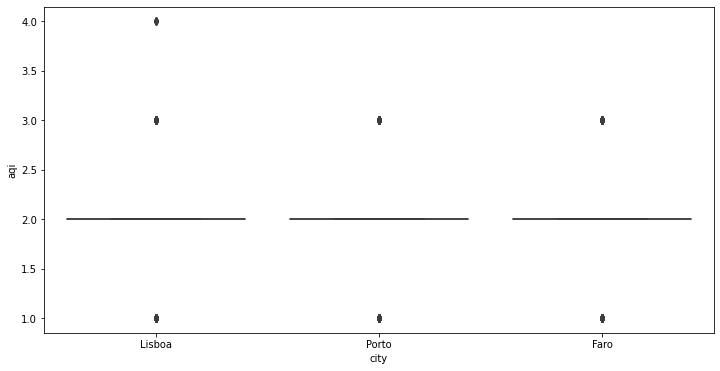

In [121]:
sns.boxplot(x = dataset.city,
            y = dataset['aqi'])

<AxesSubplot:xlabel='city', ylabel='co'>

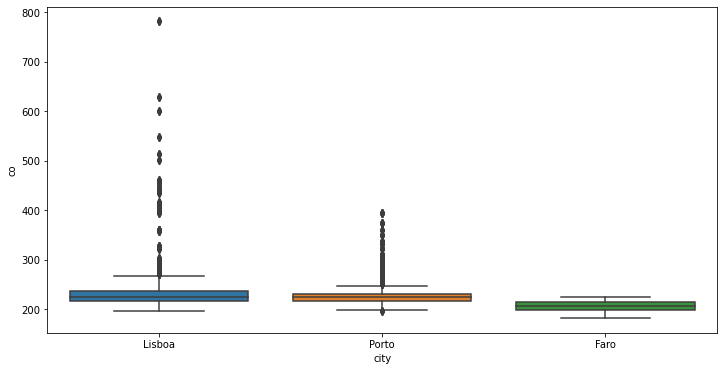

In [122]:
sns.boxplot(x = dataset.city,
            y = dataset['co'])

<AxesSubplot:xlabel='city', ylabel='no'>

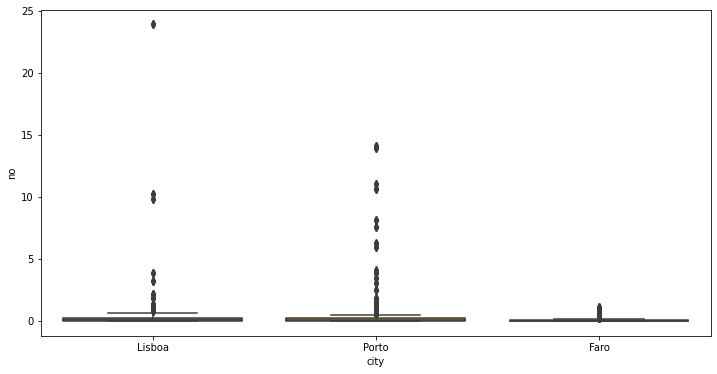

In [123]:
sns.boxplot(x = dataset.city,
            y = dataset['no'])

<AxesSubplot:xlabel='city', ylabel='no2'>

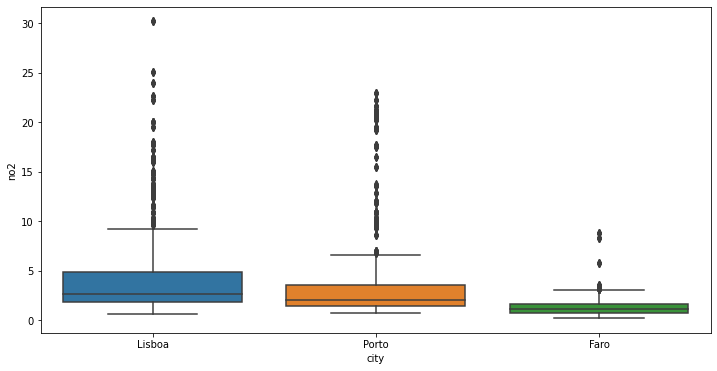

In [124]:
sns.boxplot(x=dataset.city,
            y=dataset['no2'])

<AxesSubplot:xlabel='city', ylabel='o3'>

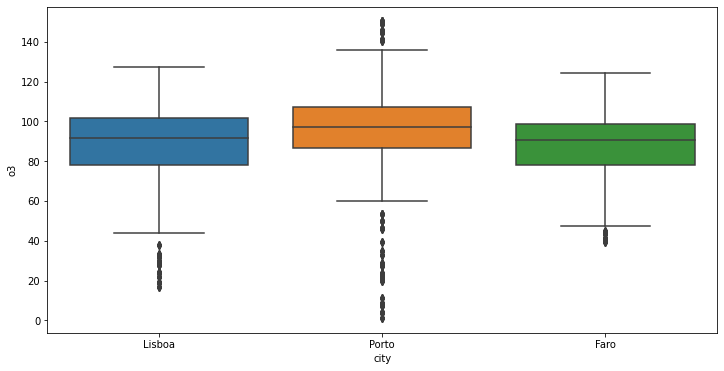

In [125]:
sns.boxplot(x = dataset.city,
            y = dataset['o3'])

<AxesSubplot:xlabel='city', ylabel='so2'>

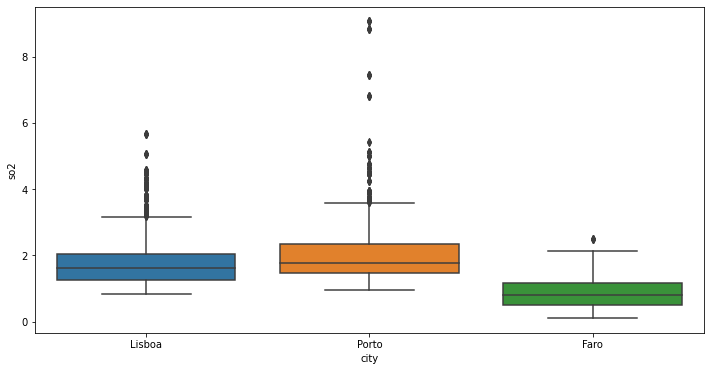

In [126]:
sns.boxplot(x = dataset.city,
            y = dataset['so2'])

<AxesSubplot:xlabel='city', ylabel='pm2_5'>

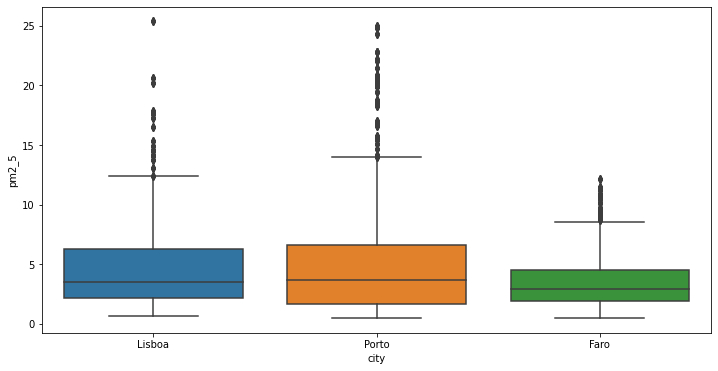

In [127]:
sns.boxplot(x = dataset.city,
            y = dataset['pm2_5'])

<AxesSubplot:xlabel='city', ylabel='pm10'>

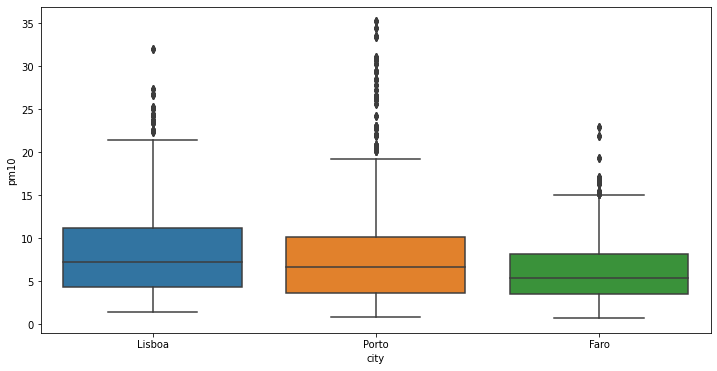

In [128]:
sns.boxplot(x = dataset.city,
            y = dataset['pm10'])

<AxesSubplot:xlabel='city', ylabel='nh3'>

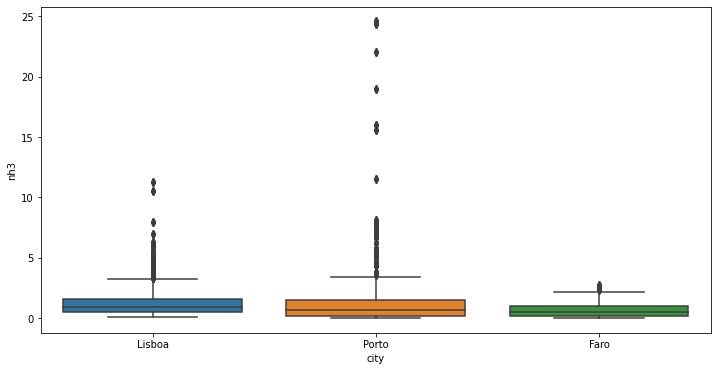

In [129]:
sns.boxplot(x = dataset.city,
            y = dataset['nh3'])

### **3.3. Problems and Solutions**

##### **Carbon Monoxide (CO)**

&emsp; &emsp; O Monóxido de Carbono é originado pela combustão incompleta de compostos de carbono. As maiores fontes deste gás tóxico para a atmosfera são o tráfego e queimadas em indústrias.

&emsp; `Lisboa`: No caso de Lisboa, a mediana está próxima do valor de 220, estando o 1º quartil acima de 200 e o 3º abaixo de 240.

&emsp; `Porto`: No que toca à cidade do Porto, o 1º e 3º quartis são muito semelhantes aos valores presentes na cidade de Lisboa, no entanto, a mediana é superior, apontando para um valor próximo de 225.

&emsp; `Faro`: Em relação a Faro, apresenta uma mediana inferior às restantes cidades, possuindo um valor de 210. Em relação ao 1º e 3º quartis, os seus valores são, aproximadamente, 190 e 220, respetivamente.

&emsp; &emsp; Com a visualização e análise dos dados pode-se aferir que as três cidades apresentam uma concentração considerável para este gás, o que pode trazer várias complicações.

&emsp; &emsp; Os problemas que este gás traz são alusivos à qualidade do ar respirável para os seres vivos, o que, sendo um gás extremamente tóxico, pode causar debilidades e até a morte, em caso de uma exposição prolongada. Por outro lado, em termos ambientais, a emissão deste gás para a atmosfera afeta a quantidade de gases do efeito de estufa, promovendo o aquecimento global e mudanças climáticas.

&emsp; &emsp; As soluções passam pela menor utilização de automóveis que consumam combustíveis fósseis; optar por transportes públicos em detrimento de transportes particulares; apostar em energias limpas; reduzir as emissões de monóxido de carbono nas grandes indústrias.

##### **Nitric Oxide (NO)**

&emsp; &emsp; O Monóxido de Nitrogénio é formado na combustão a altas temperaturas de combustível, o que se verifica nos motores dos automóveis e na queima de combustíveis fósseis.

&emsp; &emsp; A concentração deste gás, nas três cidades, não é, de todo, alarmante, isto porque, apresenta uma concentração pouco significativa do mesmo. Apesar de possuir alguns valores mais elevados nas cidades de Porto e Faro, as medianas estão perto do valor nulo e, por isso, não constitui, neste momento, um problema.


##### **Nitrogen Dioxide (NO2)**

&emsp; &emsp; O Dióxido de Nitrogénio, tal como o Óxido Nítrico, é formado através da combustão a altas temperaturas de carvão, óleo, gás ou diesel.

&emsp; `Lisboa`: A mediana aponta para um valor de 1.5, sendo que o 1º quartil é ligeiramente superior a 0.5 e o 3º quartil ligeiramente superior a 2.5.

&emsp; `Porto`: Na cidade do Porto, a mediana está um pouco acima de 1.5, o 1º quartil apresenta um valor superior a 0.5 e o 3º quartil aponta para um valor superior a 2.5.

&emsp; `Faro`: A mediana aponta para um valor aproximado de 0.7, o 1º quartil inferior a 0.5 e o 3º quartil ligeiramnete superior a 2.5.

&emsp; &emsp; Analisando e comparando estes dados, a cidade do Porto é a que aprensenta mais concentração de Dióxido de Nitrogénio de entre as três cidades, estando em 2º lugar a cidade de Lisboa e, por último, a cidade de Faro, que apresenta a menor concentração do gás. Contudo, a concentração de Dióxido de Nitrogénio está dentro do nível considerado "bom" (abaixo de 50) e, por isso, não existem problemas associados ao mesmo.

##### **Ozone (O3)**

&emsp; &emsp; O Ozono apesar de desempenhar um papel muito importante para o ser humano, a nível da estratosfera, protegendo o ser humano das radiações solares, quando está ao nível da troposfera pode causar vários problemas, caso possua grande concentração deste tipo de gás.

&emsp; `Lisboa`: A mediana está próxima de 100, estando o 1º quartil perto do valor de 60 e o 3º acima de 110.

&emsp; `Porto`: Em relação à cidade do Porto, a mediana e os quartis apresentam valores semelhantes.

&emsp; `Faro`: No que toca à cidade de Faro, a mediana e o 3º quartil são semelhantes às outras cidades, no entanto, o 1º quartil está próximo de 70, apesar de existirem mais valores abaixo do 3º quartil.

&emsp; &emsp; Comparando estes valores com os índices de qualidade do ar, no caso do Ozono, uma concentração entre 60 e 120 representa um nível razoável, representado pelo nível 2 do índice de qualidade do ar. Assim, não constitui um problema, nem para o ser humano nem para o meio ambiente e tudo o que o envolve.

##### **Sulphur dioxide (SO2)**

&emsp; &emsp; O Dióxido de enxofre é mais um dos gases libertados pela combustão de combustíveis fósseis, porém, é libertado naturalmente devido à atividade vulcânica.

&emsp; `Lisboa`: A mediana é aproximadamente 1.2, o 1º quartil é ligeiramente inferior ao valor de 1.0 e o 3º quartil apresenta um valor de aproximadamente 1.7.

&emsp; `Porto`: A mediana nesta cidade é ligeiramente superior a 1.5, o 1º quartil é superior a 1.0 e o 4º superior a 2.0. No entanto, existem vários valores registados acima do 3º quartil, ou seja, acima de 2.0.

&emsp; `Faro`: A cidade de Faro é a regista menores valores, com uma mediana próxima de 1.0, o 1º quartil pouco superior a 0 e o 4º quartil superior a 1.5. Nesta cidade, registam-se também alguns valores acima do 3º quartil.

&emsp; &emsp; Segundo os valores dos índices de qualidade do ar, os valores registados nas três cidades representam um índice de 1, ou seja, a melhor qualidade do ar, isto porque, os valores registados para Dióxido de enxofre são baixos nas três cidades estudadas.

##### **PM 2.5**

&emsp; &emsp; Consiste em partículas atmosféricas com um diâmetro inferior a 2.5 micrometros e, devido à sua dimensão microscópica, são perigosas para o ser humano, isto porque, ficam mais tempo no ar e podem entrar diretamente para a circulação sanguínea, podendo provocar  problemas cardiacos e respiratórios.

&emsp; `Lisboa`: Nesta cidade a mediana é ligeiramente superior a 2, o 1º quartil é inferior a 2 e o 3º quartil é ligeiramente inferior a 4. Contudo, existem alguns valores registados acima do 6.

&emsp; `Porto`: Na cidade do Porto, a mediana aproxima-se de 2, o 1º quartil é inferior a 2 e o 3º quartil é aproximadamente 3. Também nesta cidade registam-se vários valores acima do 3º quartil.

&emsp; `Faro`: A cidade de Faro, regista valores semelhantes à cidade de Lisboa, no entanto, o 3º quartil representa um valor próximo de 6 e um máximo acima de 10.

&emsp; &emsp; Como as concentrações registadas nas três cidades são pouco significativas, segundo o índice de qualidade de ar europeu, em que uma concentração entre 0 e 15 corresponde ao índice de valor 1, em que a qualidade do ar é muito boa, não existem problemas a identificar.

##### **PM 10**

&emsp; &emsp; Consiste em partículas inaláveis, com um diâmetro inferior a 10 micrometros. Penetrando no sistema respiratório podem provocar doenças respiratórias e, caso entre na corrente sanguínea, doenças cardíacas.

&emsp; `Lisboa`: A cidade de Lisboa apresenta uma mediana de 8, o 1º quartil é ligeiramente superior a 6 e o 3º quartil é ligeiramente superior a 10.

&emsp; `Porto`: Na cidade do Porto, a mediana é superior a 4, o 1º quartil é inferior a 4 e o 3º quartil é aproximadamente 6. Contudo, registam-se vários valores acima do máximo, sendo estes, outliers.

&emsp; `Faro`: A cidade de Faro, regista uma mediana de aproximadamente 6, o 1º quartil aponta para 4 e o 3º para aproximadamente 10.

&emsp; &emsp; Como as concentrações registadas nas três cidades são pouco significativas, tendo em conta o índice de qualidade de ar europeu, em que uma concentração entre 0 e 25 corresponde ao índice de valor 1, em que a qualidade do ar é muito boa, não existem possíveis problemas para os níveis de concentração de PM10 nestas cidades.

##### **Ammonia (NH3)**

&emsp; &emsp; É um gás que contribui para a poluição do ar, sendo a sua principal fonte natural a agricultura, contudo, é também emitido através da compostagem de materiais orgânicos, combustão, indústrias, esgotos e aterros sanitários.

&emsp; `Lisboa`: A mediana, assim como o 1º e 3º quartis, são inferiores a 1, estando o máximo abaixo de 1.5, existindo outliers acima deste máximo.

&emsp; `Porto`: A mediana aproxima-se de 0.75, o 1º quartil de 0.50 e o 3º de 1. O mínimo é cerca de 0.25 e o máximo 1.75. Neste caso, existem também outliers, com valores acima do máximo.

&emsp; `Faro`: Tanto a mediana, como o 1º e 3º quartis estão próximos de 1. O mínimo é aproximadamente 0.50 e o máximo 1.50. Existem também outliers, com valores superiores ao máximo.

&emsp; &emsp; Após esta análise é possível concluir que as concentrações de NH3 não são consideráveis, isto porque, apresentam valores baixos relativamente a outras cidades mais poluidoras. Assim, não constitui qualquer tipo de problema.

***

## **Convert back to csv**

In [130]:
dataset.to_csv('./dataset.csv', index = False)

***
# <center>**Machine Learning**<center>
***

In [131]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *

In [132]:
dataset

,city,lat,lon,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,main,description,temp,...,pm10,nh3,averageSpeedDifference,averageTimeDifference,day,year,month,week,hour,minute
0,Lisboa,38.7071,-9.13549,15,29,36,18,Clouds,few clouds,20.47,...,7.15,1.5,14,18,6,2022,4,15,13,34
1,Porto,41.14961,-8.61099,15,15,31,31,Clouds,few clouds,19.47,...,12.97,1.31,0,0,6,2022,4,15,13,34
2,Faro,37.019356,-7.93044,28,28,148,148,Clear,clear sky,22.9,...,12.71,1.11,0,0,6,2022,4,15,13,34
3,Lisboa,38.7071,-9.13549,30,30,18,18,Clouds,few clouds,20.45,...,7.15,1.5,0,0,6,2022,4,15,13,44
4,Porto,41.14961,-8.61099,15,15,31,31,Clear,clear sky,19.47,...,12.97,1.31,0,0,6,2022,4,15,13,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6860,Porto,41.14961,-8.61099,9,15,51,31,Clear,clear sky,21.61,...,8.81,1.28,6,20,5,2022,3,9,14,39
6861,Faro,37.019356,-7.93044,28,28,148,148,Clouds,broken clouds,17.88,...,1.48,0.63,0,0,5,2022,3,9,14,39
6862,Lisboa,38.7071,-9.13549,11,30,49,18,Clouds,broken clouds,21.13,...,6.23,1.55,19,31,5,2022,3,9,14,49
6863,Porto,41.14961,-8.61099,4,16,116,29,Clear,clear sky,21.35,...,8.81,1.28,12,87,5,2022,3,9,14,49


### **Pré-Processamento dos dados**

In [133]:
def convert_main(val):
    if val == 'Clouds':
        return 0
    elif val == 'Clear':
        return 1
    elif val == 'Rain':
        return 2
    elif val == 'Drizzle':
        return 3
    elif val == 'Fog':
        return 4
    elif val == 'Mist':
        return 5
    else:
        return -1

dataset['main'] = dataset['main'].apply(convert_main)
print(dataset['main'].unique())

[0 1 2 3 4 5]


In [134]:
def convert_city(val):
    if val == 'Porto':
        return 0
    elif val == 'Lisboa':
        return 1
    elif val == 'Faro':
        return 2
    else:
        return -1

dataset['city'] = dataset['city'].apply(convert_city)
print(dataset['city'].unique())

[1 0 2]


In [135]:
def convert_description(val):
    if val == 'few clouds':
        return 0
    elif val == 'scattered clouds':
        return 1
    elif val == 'light rain':
        return 2
    elif val == 'light intensity shower rain':
        return 3
    elif val == 'overcast clouds':
        return 4
    elif val == 'fog':
        return 5
    elif val == 'light intensity drizzle':
        return 6
    elif val == 'clear sky':
        return 7
    elif val == 'broken clouds':
        return 8
    elif val == 'light intensity drizzle rain':
        return 9
    elif val == 'moderate rain':
        return 10
    elif val == 'heavy intensity shower rain':
        return 11
    elif val == 'mist':
        return 12
    else:
        return -1

dataset['description'] = dataset['description'].apply(convert_description)
print(dataset['description'].unique())

[ 0  7  1  8  2  9  3 10  4 11  5 12  6]


### **Previsão da temperatura**

In [136]:
y = dataset['temp'].to_frame()
x = dataset.drop(['temp', 'lat', 'lon'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, np.ravel(y), test_size = 0.2, random_state = 2021)

In [137]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [9],
    'max_features': [4],
    'n_estimators': [490],
    'random_state': [2022]
}

rf = RandomForestRegressor()

grid = HalvingGridSearchCV(rf, param_grid, cv = 3, n_jobs = -1, factor = 2, refit = True, verbose = 0)

grid.fit(x_train, y_train)

print(grid.best_params_)
print(grid.best_estimator_)


predictions = grid.predict(x_test)

print("%f mae" %(mean_absolute_error(y_test, predictions)))

{'bootstrap': True, 'max_depth': 9, 'max_features': 4, 'n_estimators': 490, 'random_state': 2022}
RandomForestRegressor(max_depth=9, max_features=4, n_estimators=490,
                      random_state=2022)
0.171281 mae


### **Previsão da velocidade média dos automóveis**

In [138]:
y = dataset['currentSpeed'].to_frame()
x = dataset.drop(['currentSpeed', 'lat', 'lon'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, np.ravel(y), test_size = 0.2, random_state = 2021)

In [139]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [9],
    'max_features': [4],
    'n_estimators': [180],
    'random_state': [2022]
}

rf = RandomForestRegressor()

grid = HalvingGridSearchCV(rf, param_grid, cv = 3, n_jobs = -1, factor = 2, refit = True, verbose = 0)

grid.fit(x_train, y_train)

print(grid.best_params_)
print(grid.best_estimator_)


predictions = grid.predict(x_test)

print("%f mae" %(mean_absolute_error(y_test, predictions)))

{'bootstrap': True, 'max_depth': 9, 'max_features': 4, 'n_estimators': 180, 'random_state': 2022}
RandomForestRegressor(max_depth=9, max_features=4, n_estimators=180,
                      random_state=2022)
0.265446 mae


### **Previsão do índice da qualidade do ar**

In [140]:
y = dataset['aqi']
x = dataset.drop(['aqi', 'lat', 'lon'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 2021)

In [141]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [9],
    'max_features': [4],
    'n_estimators': [130],
    'random_state': [2022]
}

rf = RandomForestRegressor()

grid = HalvingGridSearchCV(rf, param_grid, cv = 3, n_jobs = -1, factor = 2, refit = True, verbose = 0)

grid.fit(x_train, y_train)

print(grid.best_params_)
print(grid.best_estimator_)


predictions = grid.predict(x_test)

print("%f mae" %(mean_absolute_error(y_test, predictions)))

{'bootstrap': True, 'max_depth': 9, 'max_features': 4, 'n_estimators': 130, 'random_state': 2022}
RandomForestRegressor(max_depth=9, max_features=4, n_estimators=130,
                      random_state=2022)
0.049999 mae


C:\Users\ASUS\anaconda3\envs\aula1\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
